In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from thermo.group_contribution.joback import Joback
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def estimate_melting_point_joback(smiles: str) -> float:
    """
    Estimate the melting point (K) of a molecule given a SMILES string
    using the Joback group contribution method from the thermo library.

    Returns:
        Melting point in Kelvin.

    Raises:
        ValueError if the SMILES string is invalid or estimation fails.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES: {smiles}")

    # Thermo's Joback works by internally splitting into groups
    joback = Joback(mol)

    if hasattr(joback, "status") and joback.status != "OK":
        # raise RuntimeError(f"Joback fragmentation status not OK: {joback.status}")
        return np.nan

    # Tm returns melting temperature in Kelvin according to Joback
    tm = joback.Tm(joback.counts)
    return tm

df = pd.read_csv('../data/test.csv')

melt_pred = []
for i in range(len(df)):
    smi = df['SMILES'].iloc[i]
    pred = estimate_melting_point_joback(smi)
    melt_pred.append(pred)

df['pred'] = melt_pred
print(f'There are {df['pred'].isna().sum()}.')
mean_pred = df['pred'].mean(skipna=True)
df['pred'] = df['pred'].fillna(mean_pred)

There are 46.


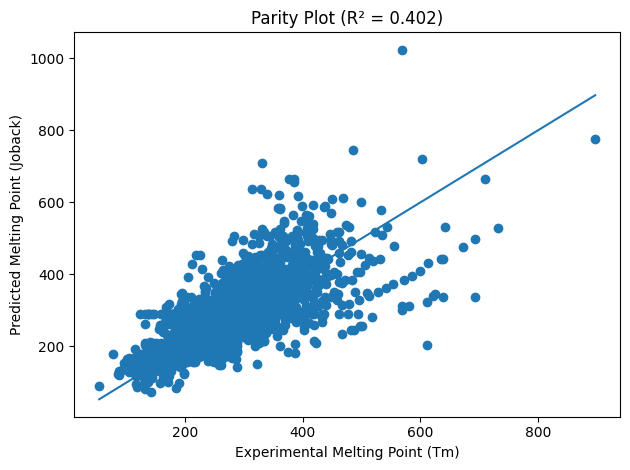

In [ ]:
# Extract true and predicted values
y_true = df['Tm'].values
y_pred = df['pred'].values

# Compute R²
r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

# Create parity plot
plt.figure()
plt.scatter(y_true, y_pred)
plt.plot(
    [y_true.min(), y_true.max()],
    [y_true.min(), y_true.max()],
)
plt.xlabel('Experimental Melting Point (Tm)')
plt.ylabel('Predicted Melting Point (Joback)')
plt.title(f'Parity Plot (R² = {r2:.3f})')
plt.tight_layout()
plt.show()